# XGBoost Hyperparameter Tuning

Im vorherigen Notebook wurde XGBoost als eins der geeigneten Modelle identifiziert. In diesem Notebook wird nun das XGBoost-Modell optimiert.

In [1]:
import helper
from helper import *
import importlib
importlib.reload(helper)

df = load_merged_data(only_standard_refuelling=True)

In [2]:
import xgboost as xgb

In [3]:
input_columns = [
    'refuellingTimePoint', 'refuellingTimePoint_5', 'refuellingTimePoint_10', 'refuellingTimePoint_15', 'refuellingTimePoint_30', 'refuellingTimePoint_60',
    'bufferChargingDegree', 'bufferChargingDegree_5', 'bufferChargingDegree_10', 'bufferChargingDegree_15', 'bufferChargingDegree_30', 'bufferChargingDegree_60',
    'Anheizen', 'Anzünden', 'Ausbrennen', 'Ausgeschaltet', 'Automatik', 'Vorbelüften', 'Zündung bereit',
    'Year sin', 'Year cos',
    'refuellingQuantity',
    'residualOxygen', 'flueGasTemperature',
    'bufferTemperatureTop', 'bufferTemperatureMiddleTop', 'bufferTemperatureMiddle', 'bufferTemperatureMiddleBottom', 'bufferTemperatureBottom',
    'bufferUsableEnergyMax', 'bufferUsableEnergyActual',
    'outsideTemperature',
    'weatherTemperature', 'weatherWindX', 'weatherWindY',
    'weatherTemperature_6', 'weatherWindX_6', 'weatherWindY_6',
    'weatherTemperature_12', 'weatherWindX_12', 'weatherWindY_12',
    'weatherTemperature_18', 'weatherWindX_18', 'weatherWindY_18',
    'weatherTemperature_24', 'weatherWindX_24', 'weatherWindY_24'
]

Im nächsten Schritt wird ein XGBoost-Modell trainiert. Dazu werden verschiedene Hyperparameter-Kombinationen ausprobiert und die beste Kombination ausgewählt.

Da aufgrund der Vielzahl an Parametern und deren verschiedenen möglichen Ausprägungen nicht alle Kombinationen getestet werden können, wird ein `RandomizedSearchCV` verwendet. Im Gegensatz zu `GridSearchCV` werden dabei zufällige Kombinationen ausgewählt und getestet. Die Anzahl der Kombinationen kann über den Parameter `n_iter` festgelegt werden.
Um die Güte zu bwerten wird auch hier auf `MAPE` und `SkipFirstTimeSeriesSplit` zurückgegriffen.   

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform

df_train, df_val = train_test_split(df, test_size=0.25, shuffle=False)
X_train, y_train = split_xy(df_train, input_columns)
X_val, y_val = split_xy(df_val, input_columns)

def custom_obj(y_true, y_pred):
    grad = 2 * y_pred / y_true - 2
    hess = 2 / y_true
    return grad, hess

model_params = {
    'eval_metric': 'mape',
}

xgb_model = xgb.XGBRegressor(**model_params)

param_distributions = {
    'objective': ['reg:squarederror', custom_obj],
    'n_estimators': randint(1000, 2000),
    'learning_rate': uniform(0.04, 0.1),
    'max_depth': randint(5, 20),
    'early_stopping_rounds': randint(1, 50)
    
} 

cv = SkipFirstTimeSeriesSplit(n_splits=5, n_skip_splits=2)

grid_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    cv=cv,
    scoring='neg_mean_absolute_percentage_error',
    verbose=2,
    n_jobs=1,
    return_train_score=True,
    error_score='raise',
    n_iter=30
)

grid_search.fit(X_train[::100], y_train[::100], eval_set=[(X_val, y_val)], verbose=False)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END early_stopping_rounds=42, learning_rate=0.06131020544510655, max_depth=5, n_estimators=1796, objective=<function custom_obj at 0x137a09440>; total time=   7.8s
[CV] END early_stopping_rounds=42, learning_rate=0.06131020544510655, max_depth=5, n_estimators=1796, objective=<function custom_obj at 0x137a09440>; total time=  14.3s
[CV] END early_stopping_rounds=42, learning_rate=0.06131020544510655, max_depth=5, n_estimators=1796, objective=<function custom_obj at 0x137a09440>; total time=  13.2s
[CV] END early_stopping_rounds=40, learning_rate=0.11449601928555306, max_depth=9, n_estimators=1292, objective=<function custom_obj at 0x137a09440>; total time=   8.8s
[CV] END early_stopping_rounds=40, learning_rate=0.11449601928555306, max_depth=9, n_estimators=1292, objective=<function custom_obj at 0x137a09440>; total time=   8.4s
[CV] END early_stopping_rounds=40, learning_rate=0.11449601928555306, max_depth=9, n_estimator

RandomizedSearchCV(cv=SkipFirstTimeSeriesSplit(gap=0, max_train_size=None, n_skip_splits=2,
             n_splits=5, test_size=None),
                   error_score='raise',
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='mape',
                                          feature_t...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x137d321d0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x137d32410>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x130996750>,
                                        'objective': ['reg:squarederror',
                                                      <function custom_obj at 0x137a09440>]},
                   return_train_score=True,
                   scoring='neg_mean_absolute_percentage_error', verbose=2)

Nach dem Training können die Parameterkombination nach dem besten `mean_test_score` sortiert werden, sodass die besten Parameter gefunden werden können.

In [5]:
result_df = pd.DataFrame(grid_search.cv_results_)
result_df = result_df[['params', 'mean_fit_time', 'mean_test_score', 'mean_train_score']]

# Umwandeln von negativen Werten in positive Werte
result_df['mean_test_score'] = -result_df['mean_test_score']
result_df['mean_train_score'] = -result_df['mean_train_score']

# Sortieren nach mean_test_score
result_df = result_df.sort_values(by='mean_test_score', ascending=True)

result_df

,params,mean_fit_time,mean_test_score,mean_train_score
15,"{'early_stopping_rounds': 41, 'learning_rate':...",13.192259,0.258584,0.080210
2,"{'early_stopping_rounds': 46, 'learning_rate':...",10.417004,0.258595,0.094758
8,"{'early_stopping_rounds': 4, 'learning_rate': ...",6.410471,0.259281,0.103384
14,"{'early_stopping_rounds': 41, 'learning_rate':...",7.557628,0.259889,0.105079
11,"{'early_stopping_rounds': 8, 'learning_rate': ...",3.528507,0.260747,0.134100
16,"{'early_stopping_rounds': 22, 'learning_rate':...",11.022026,0.260868,0.080643
22,"{'early_stopping_rounds': 36, 'learning_rate':...",8.029666,0.261070,0.120649
3,"{'early_stopping_rounds': 4, 'learning_rate': ...",4.441480,0.261122,0.085617
26,"{'early_stopping_rounds': 43, 'learning_rate':...",18.321786,0.261167,0.081772
19,"{'early_stopping_rounds': 3, 'learning_rate': ...",4.165224,0.261508,0.126991


In [6]:
# print best parameters
grid_search.best_params_

{'early_stopping_rounds': 41,
 'learning_rate': 0.08221980827709024,
 'max_depth': 14,
 'n_estimators': 1220,
 'objective': <function __main__.custom_obj(y_true, y_pred)>}

# Finales Model

Mithilfe des Hyperparameter Tunings wurden die besten Parameter für das Modell gefunden.
Final kann nun dieses Modell noch einmal trainiert werden.

In [7]:
model_params = {
    'eval_metric': 'mape',
    'early_stopping_rounds': 50
}
model_params.update(grid_search.best_params_)

xgboostTrainer = FurnaceModelTrainer(
    df, input_columns, slice_step=100,
    cross_validation_splitter=SkipFirstTimeSeriesSplit(n_splits=5, n_skip_splits=2),
    model_builder=lambda: xgb.XGBRegressor(**model_params), fit_params={'verbose': False}, generate_eval_set=True)
xgboostTrainer.cross_validation()

Finished fold
    Train Duration: 9.885485172271729 seconds
    Train Size: 35496
    MAPE: 0.2181429244982684
    MSE: 30.38980920638809
    RSME: 5.5126952760322325
Finished fold
    Train Duration: 16.22159218788147 seconds
    Train Size: 47328
    MAPE: 0.23451618731107615
    MSE: 192.86442371389677
    RSME: 13.887563634917997
Finished fold
    Train Duration: 16.559651851654053 seconds
    Train Size: 59160
    MAPE: 0.2162027721849041
    MSE: 74.76591369562951
    RSME: 8.64672849669917
Average MAPE: 0.2229539613314162
Average MSE: 99.34004887197146
Average RSME: 9.966947821272642


0.2229539613314162

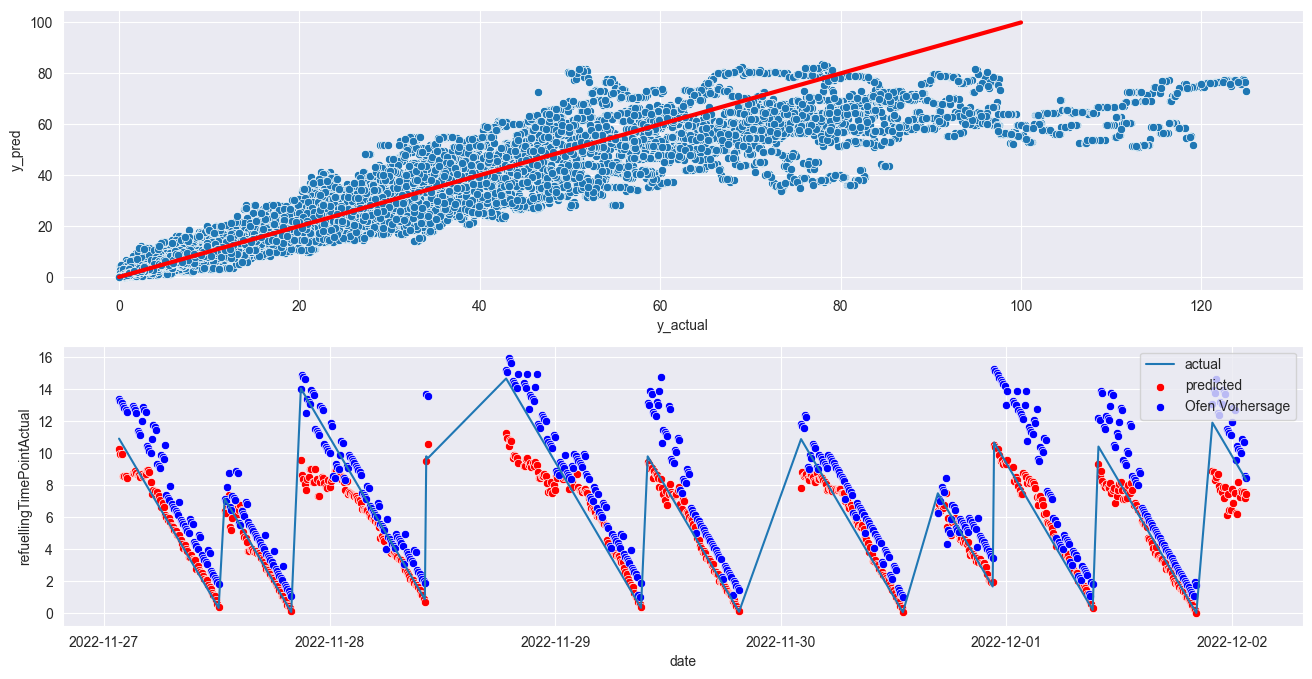

In [8]:
xgboostTrainer.visualize_split()

### Feature Importance

Um einen Einblick in die Funktionsweise des Modells zu erhalten, wird die Wichtigkeit der einzelnen Features betrachtet. Dazu wird die `plot_importance()` Methode von XGBoost verwendet. Diese gibt die Wichtigkeit der einzelnen Features als Bar Chart aus. Dabei wird die Wichtigkeit der Features in der Reihenfolge der Wichtigkeit absteigend sortiert.

Bei der Betrachtung der Feature Importance können einige Erkenntnisse gewonnen werden:
1. Als sehr wichtiges Feature wird die Vorhersage des Ofens selbst angegeben. Die Vorhersage des Ofens ist nicht überraschend, da dies bereits die Zielgröße vorhersagen soll.
2. Ebenfalls sehr wichtig wird die Jahreszeit (`Year sin` und `Year cos`) angegeben. Bereits in der Explorativen Datenanalyse wurde die starke Saisonalität der Daten festgestellt. Die Jahreszeit ist daher ein sehr wichtiges Feature.
3. Die Außentemperatur, die direkt von der Heizung gemessen wird (`outsideTemperature`), ist sehr viel relevanter als die Temperatur der historischen Wetterdaten (`weatherTemperature`).
4. Sowohl beim aktuellen Wetter als auch bei der Wettervorhersage ist die Temperatur sehr viel relevanter als der Wind.
5. Die Ofenzustände spielen nur eine geringe Rolle.
6. Bei den Werten zum aktuellen Brennvorgang ist die Abgastemperatur (`flueGasTemperature`) sehr relevant. Der Restsauerstoffgehalt (`residualOxygen`) ist jedoch sehr viel weniger relevant.

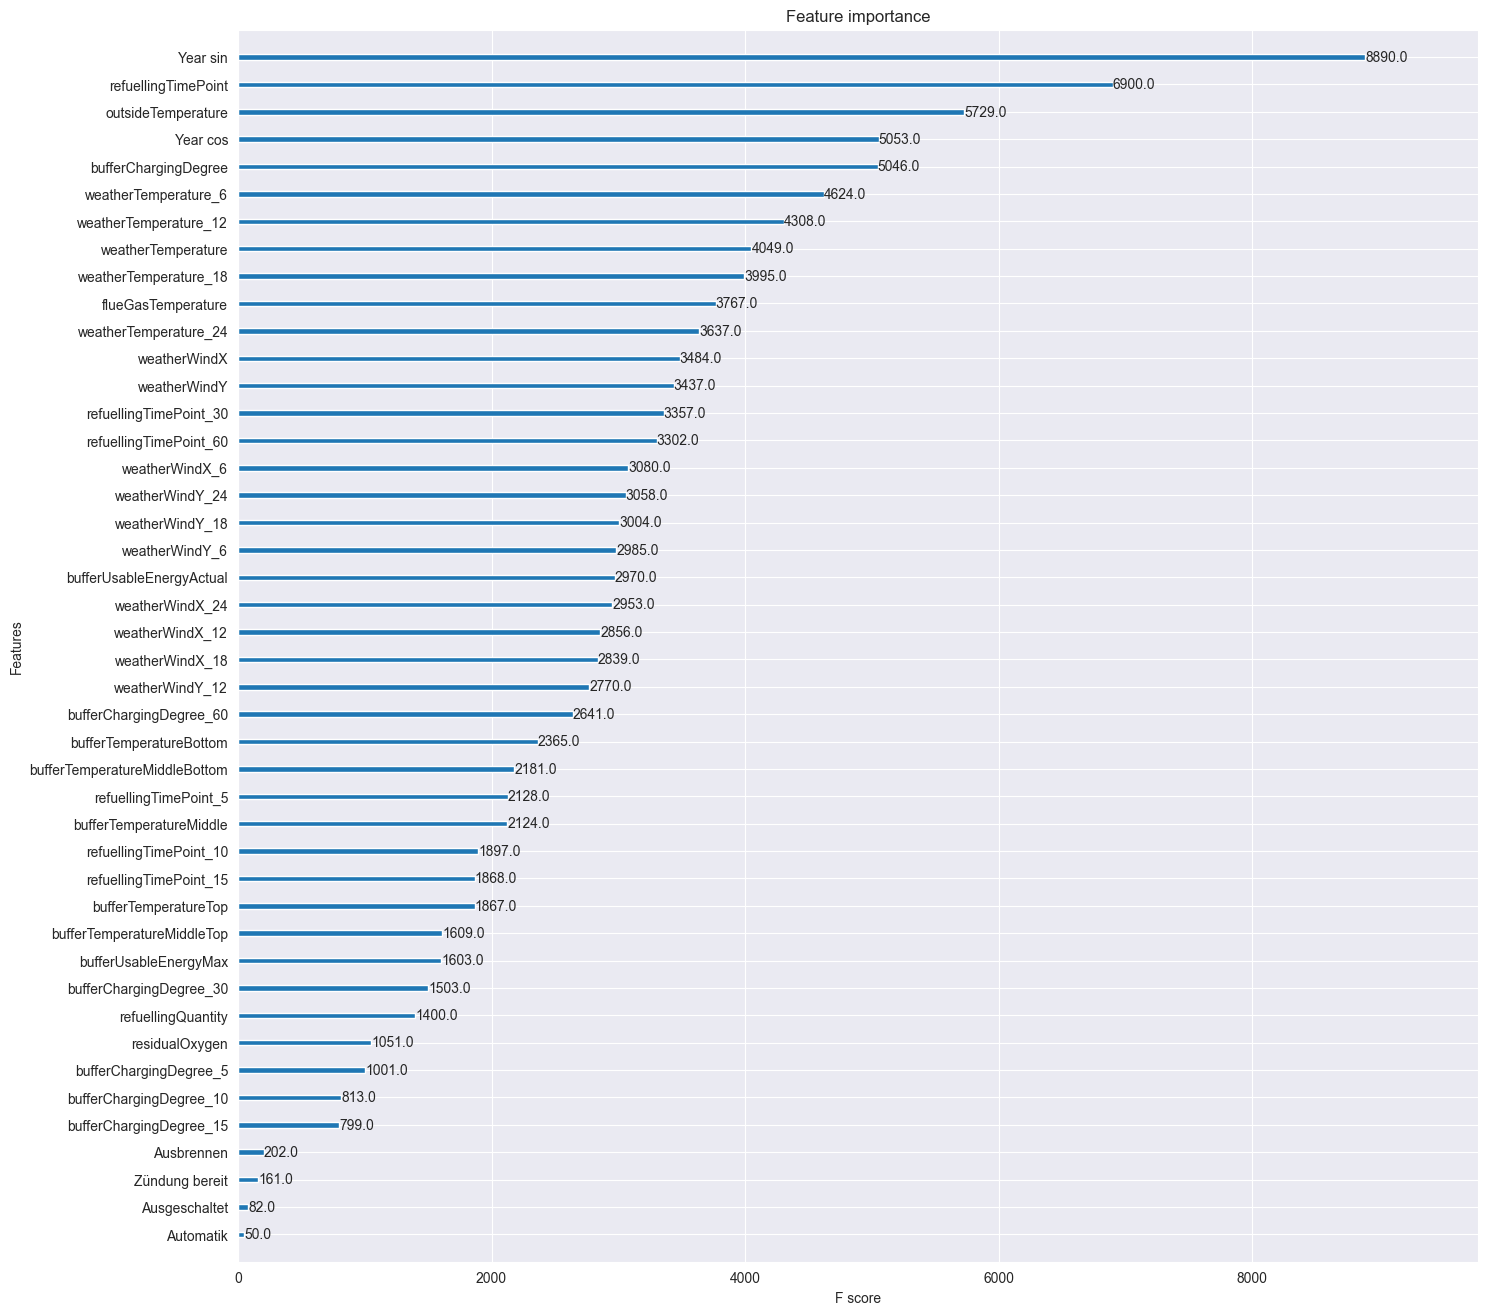

In [9]:
xgboostTrainer.train()
xgb.plot_importance(xgboostTrainer.model)
plt.gcf().set_size_inches(16, 16)
